In [1]:
from fastai import *
from fastai.text import *

In [16]:
! pwd

/home/ec2-user/SageMaker/ULMFit


In [17]:
ROOT_PATH = Path('/home/ec2-user/SageMaker/ULMFit')
MODEL_PATH = Path(ROOT_PATH/'model')
DATA_PATH = Path(ROOT_PATH/'data')

In [9]:
sample_path = untar_data(URLs.IMDB_SAMPLE)
sample_path.ls()

[PosixPath('/home/ec2-user/.fastai/data/imdb_sample/texts.csv')]

In [10]:
sample_df = pd.read_csv(sample_path/'texts.csv')
sample_df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [15]:
sample_data_lm = TextDataBunch.from_csv(sample_path, 'texts.csv')
sample_data_lm.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


In [18]:
sample_data_lm.save(MODEL_PATH/'sample_data_lm')

In [22]:
sample_data = load_data(MODEL_PATH, file='sample_data_lm')

In [25]:
sample_data

TextClasDataBunch;

Train: LabelList (799 items)
x: TextList
xxbos i love xxmaj seth xxmaj green . xxmaj his appearances on that 70s ' xxmaj show is always worth watching but last night , i felt the show needed to xxunk . xxmaj four single young guys inherit a xxmaj new xxmaj york xxmaj city apartment that most of us would die for . xxmaj the grandmother must have been an xxunk to have such space in the first place . xxmaj so i felt the need for realism should have been brought out . xxmaj anyway the plot about four best friends getting this apartment was not believable . i would have been thrilled if they had to move in with one of their parents which would have provided great humor and dysfunctional about the show 's set up . xxmaj there did not seem to be much humor in it . i am only watching it because it falls before xxmaj my xxmaj name is xxmaj earl on a winning xxmaj xxunk night . i think they should go back , xxunk this series , and start over . xxmaj we need more family involv

In [26]:
sample_data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


In [36]:
sample_data.train_ds[0][0].data[:10]

array([   2,   19,  143,    5, 3827,    5, 1687,   11,    5,   41])

In [35]:
sample_data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [2]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/ec2-user/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/unsup'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/test'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/README'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train')]

In [5]:
(path/'train/pos').ls()

[PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/4365_9.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/3103_7.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/779_10.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/5274_7.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/4965_9.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/5835_10.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/5679_10.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/12312_10.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/1750_10.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/11600_7.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/2828_9.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/2217_7.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/5830_8.txt'),
 PosixPath('/home/ec2-user/.fastai/data/imdb/train/pos/7886_10.txt'),
 PosixPath('/home/ec2-user/

In [6]:
with open(path/'train/pos/3908_10.txt') as f: d = f.read()
    
print(d)

I had no idea that Mr. Izzard was so damn funny, It really boggles the mind that he is not more well known! His command over the crowd and his timing is perfect.The monologue about Star Wars will kill ya too! If only all the stand up performers had his wit...


In [37]:
data_lm = (TextList.from_folder(path)
           .filter_by_folder(include=['train', 'test'])
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=64))



In [38]:
data_lm.save(MODEL_PATH/'data_lm.pkl')

In [39]:
data_lm = load_data(MODEL_PATH, 'data_lm.pkl', bs=64)

In [40]:
data_lm.show_batch()

idx,text
0,"tremendous sex scene with xxmaj nikki xxmaj fritz , a dude and a bottle of oil which is out of this world ( no pun intended ) . xxmaj unfortunately , in the trimmed version that scene is almost completely chopped out , as are all the other sex scenes . xxmaj rated or unrated it is still fun to watch all the siblings of bigger stars ( xxmaj stallone"
1,"but i think xxmaj connery would still be formidable in a wheelchair . xxbos xxmaj robert deniro and xxmaj eddie xxmaj murphy , what a team . xxmaj while xxmaj rene xxmaj russo , xxmaj william xxmaj xxunk , and that guy from the xxmaj everyday video are alongside for the ride . xxmaj this is a funny and a great movie . xxmaj not only is it that ,"
2,"climax of the meal . i expected deep heartfelt observations , but i got some vague mystical ramblings . xxmaj the speech had such a minimal impact that i hardly remember it . \n \n xxmaj but this understated film leaves a lasting impression . xxmaj the warmth it generates is in contrast to its austere backdrop . xxmaj you will leave the theater wanting to go out and"
3,. i feel bad for the singers on the show who wee really starting to grow on me . i wish they would reconsider and put the show back on . i think it was a hasty move to cancel . xxmaj my only complaint about the show is i did not care to much for the judges . xxbos xxmaj the subject matter of this film is potentially depressing
4,"not sure who i 'd recommend it too as it mixes various genres , i guess someone who maybe fancies something a little bit different and generally well made . xxmaj if you can find a copy give it a go , i 'm glad i did . xxbos xxmaj after 10 viewings in 20 years i too think this was the xxmaj crazy xxmaj gang 's best effort on"


### Creating a language model on top of WikiText 103

In [41]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [42]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


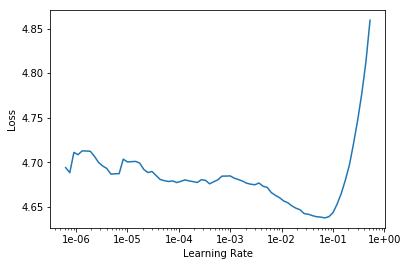

In [43]:
learn.recorder.plot(skip_end=15)

In [44]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.103140,3.975021,0.296857,39:45


In [46]:
learn.save(MODEL_PATH/'stage-1')

### This creates an RNN a Recurrent Neural Network

```python
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
```

This creates a learner off the wikitext pretrained model

`drop_mult` is adding a DropOut layer for regularisation

While our first train what we're doing is training the last layers. This takes insanely long. 

We then unfreeze and train all the layers.

In [47]:
learn.load(MODEL_PATH/'stage-1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (45000 items)
x: LMTextList
xxbos xxmaj i`ve seen this movie twice , both times on xxmaj cinemax . xxmaj the first time in it`s unrated version which is soft - core porn at it`s best and the second time in a trimmed down ( cut all the sex and most of the nudity out ) version which was entertaining in a typical beach movie sort of way . xxmaj the unrated version has a tremendous sex scene with xxmaj nikki xxmaj fritz , a dude and a bottle of oil which is out of this world ( no pun intended ) . xxmaj unfortunately , in the trimmed version that scene is almost completely chopped out , as are all the other sex scenes . xxmaj rated or unrated it is still fun to watch all the siblings of bigger stars ( xxmaj stallone , xxmaj sheen , xxmaj travolta , etc ; ) trying to act . xxmaj we also get appearances by b - queen xxmaj linnea xxmaj quigley and xxmaj burt xxmaj ward ( xxmaj robin from the old xxmaj batman series ) .,xxbos xxmaj the fil

In [48]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


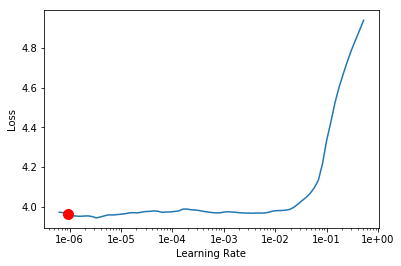

In [49]:
learn.lr_find()
learn.recorder.plot(suggestion=True, skip_end=15)

In [50]:
learn.fit_one_cycle(15, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.840966,3.869613,0.307620,40:19
1,3.793058,3.813565,0.314675,40:20
2,3.726823,3.782688,0.318904,40:21
3,3.708018,3.764738,0.321531,40:21
4,3.687446,3.746654,0.323544,40:23
5,3.632394,3.736200,0.325309,40:21
6,3.607625,3.729965,0.325968,40:22
7,3.550811,3.725530,0.327320,40:21
8,3.514500,3.724190,0.327868,40:22
9,3.451022,3.727584,0.328238,40:21


In [51]:
learn.save(MODEL_PATH/'stage-2')